# Tutorial 2 - Extracting kinetic reaction rates in 1D

## Introduction

In this notebook, we are going to illustrate how to extract the additional information required to compute a reaction rate from transition state theory. The notebook uses simulation data generated using the umbrella sampling technique for the proton transfer in a formic acid dimer. It continues on the workflow done in Tutorial 1, although it repeats some steps in constructing the free energy profile as those data is required to proceed with the workflow of the current notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_feps
from thermolib.thermodynamics.histogram import Histogram1D, plot_histograms
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import CVComputer, ColVarReader
from thermolib.thermodynamics.cv import CoordinationNumber, LinearCombination
from thermolib.kinetics.rate import RateFactorEquilibrium
from thermolib.units import *
from thermolib.constants import *

import numpy as np, matplotlib.pyplot as pp, time, os

In [3]:
prefix = 'basic_kinetic_'
fn_meta = 'data/formic_acid_dimer/wham_input.txt'

## Construct free energy profile

We first construct the WHAM 1D free energy profile.

STEP 1 - read trajectories

In [4]:
colvar_reader = ColVarReader([0], units=['au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

STEP2 - estimate correlation times

In [5]:
corrtimes = decorrelate(trajectories)

/home/lvduyfhu/miniconda3/envs/thermolib/lib/python3.14/site-packages/thermolib/tools.py:960: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


STEP 3 - construct FEP accounting for the MD correlation time as well as covariance between FEP points

In [6]:
bins = np.arange(-1.55, 1.55, 0.01)
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.012s
  bias poten. : 00h 00m 00.014s
  solve scf   : 00h 00m 00.277s
  error est.  : 00h 00m 01.310s
  TOTAL       : 00h 00m 01.614s
---------------------------------------------------------------------


In [7]:
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-1.5,-0.2,0.2,1.5])
fep.set_ref(ref='r')

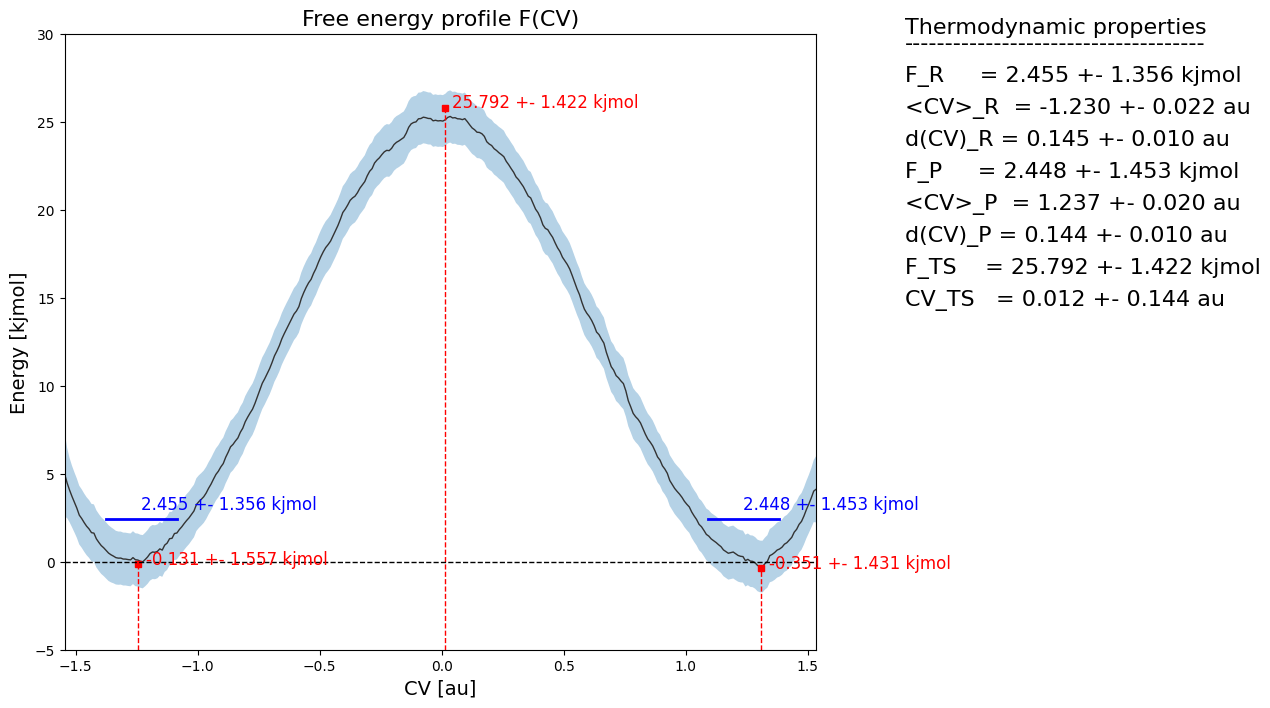

In [8]:
fep.plot(flims=[-5,30])

## Compute rate prefactor

The rate from transition state theory is defined as:

\begin{align}
    k^{TST} = A \frac{e^{-\beta F(q^{TS})}}{\int e^{-\beta F(q)}dq}
\end{align}

with

\begin{align}
    A = \sqrt{\frac{1}{2\pi\beta}}\left\langle \left|\vec{\nabla}_x Q\right| \right\rangle_{TS}
\end{align}

The second factor in $k^{TST}$ can be extracted purely from the free energy profile, however, the $A$ factor requires additional information extracted from simulations that samples the transition state. This is the first thing we will need to do.

To this end, we first define the collective variable used for the construction of the FEP

In [9]:
#CV definition
C1 = CoordinationNumber([[0,9]], r0=1.4*angstrom)
C2 = CoordinationNumber([[7,9]], r0=1.4*angstrom)
C3 = CoordinationNumber([[2,4]], r0=1.4*angstrom)
C4 = CoordinationNumber([[5,4]], r0=1.4*angstrom)
CV = LinearCombination([C1,C2,C3,C4], [1., -1., -1., 1.])

To extract the rate prefactor A from simulation trajectories (possibly biased) around the transition state, we first make an educated guess of which umbrella sampling trajectories are indeed around the TS and plot a histogram of these trajectories to double check before we continue.

<Figure size 640x480 with 0 Axes>

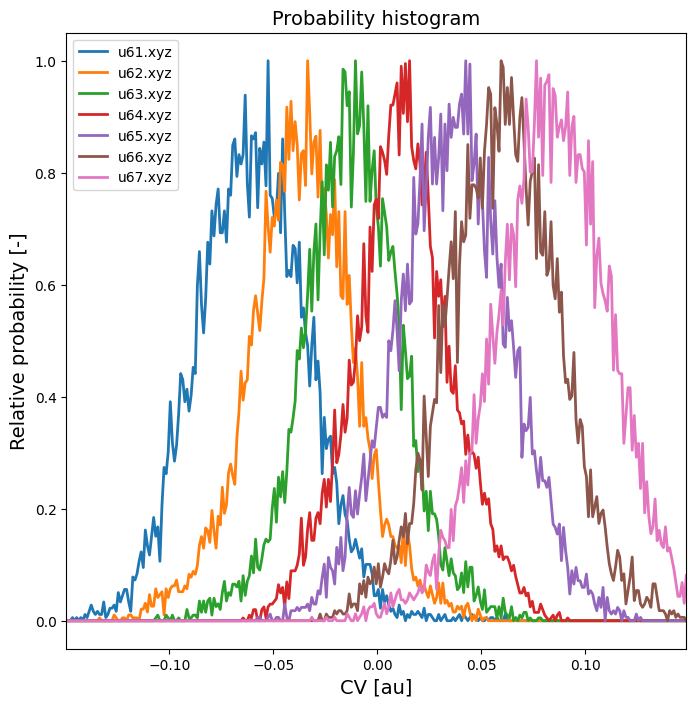

In [10]:
fns = ['%s/colvars/u%i.xyz' %(os.path.dirname(fn_meta),i) for i in range(61,68)]
labels = [fn.split('/')[-1] for fn in fns]
hists = []
bins = np.arange(-0.15, 0.15, 0.001)
cv_comp = CVComputer([CV])
for fn in fns:
    cv_data = cv_comp(fn)
    hist = Histogram1D.from_single_trajectory(cv_data, bins)
    hists.append(hist)
plot_histograms(hists, labels=labels)

We are going to chose the trajectory `u64.xyz` as it has a high probabilty around the transition state (which is around 0.0). We could also use multiple trajectory (e.g. `u63.xyz` and `u64.xyz`), but that will not allow to use block averaging to estimate correlation time and error.

We initialize a RateFactor instance for an Equilibrium simulation (eg. umbrella around TS). For this, we need to associate a width to the CV value in the transition state to allow for defining a dirac function and extracting TS states from the trajectories determined above. We do this by setting a CV_TS_lims interval around the TS using the user specified CV_TS_Delta. From the histogram above, we choose CV_TS_Delta as 0.01, meaning that basically the interval [-0.01,0.01] will be recognized ad the TS.

In [11]:
CV_TS_Delta = 0.01
CV_TS_lims = [fep.ts.get_cv()-CV_TS_Delta, fep.ts.get_cv()+CV_TS_Delta]
rate = RateFactorEquilibrium(CV, CV_TS_lims, temp, CV_unit='au')

Now we read all TS samples from the above determined trajectory and compute the corresponding A factor values.

In [12]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate.process_trajectory(fn, finish=False, momenta='analytical', verbose=True)
rate.finish(fn=prefix+'rate_factor_samples.txt')

Estimating rate factor from trajectory data/formic_acid_dimer/colvars/u64.xyz for TS=[0.002,0.022] au using analytical momentum integration


Use the extracted samples to compute the TS-constrained ensemble average of the rate prefactor (i.e. the A factor) and use block averaging to estimate correlation time and error bar.

<Figure size 640x480 with 0 Axes>

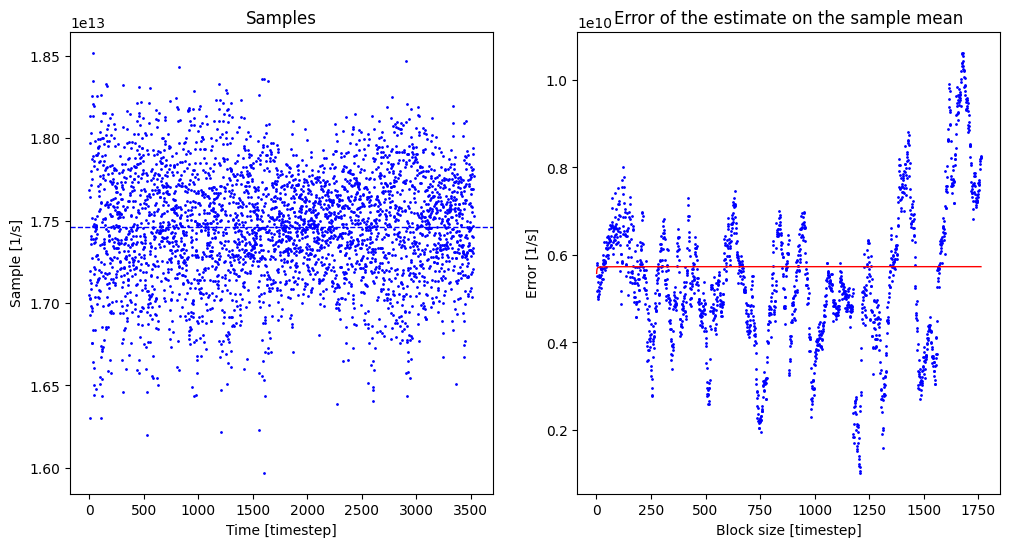

Rate factor with block averaging:
---------------------------------
  A = 1.746 10^+13 +- 1.146 10^+10 au/s (3527 TS samples, int. autocorr. time = 1.055 timesteps)



In [13]:
A, A_dist = rate.result_blav(plot=True, fitrange=[1,300])

Compute rate and its error

In [14]:
rate_results = rate.compute_rate(fep, verbose=True)

k_F  = 2.863 10^+08 <= 7.490 10^+08 <= 1.623 10^+09 1/s
dF_F = 20.495 +- 1.970 kjmol
k_B  = 2.484 10^+08 <= 6.928 10^+08 <= 1.564 10^+09 1/s
dF_B = 20.699 +- 2.088 kjmol


## Add kinetic information to FEP plot

Finally, we make a summarizing plot with all FEP thermodynamics and all rate kinetics.

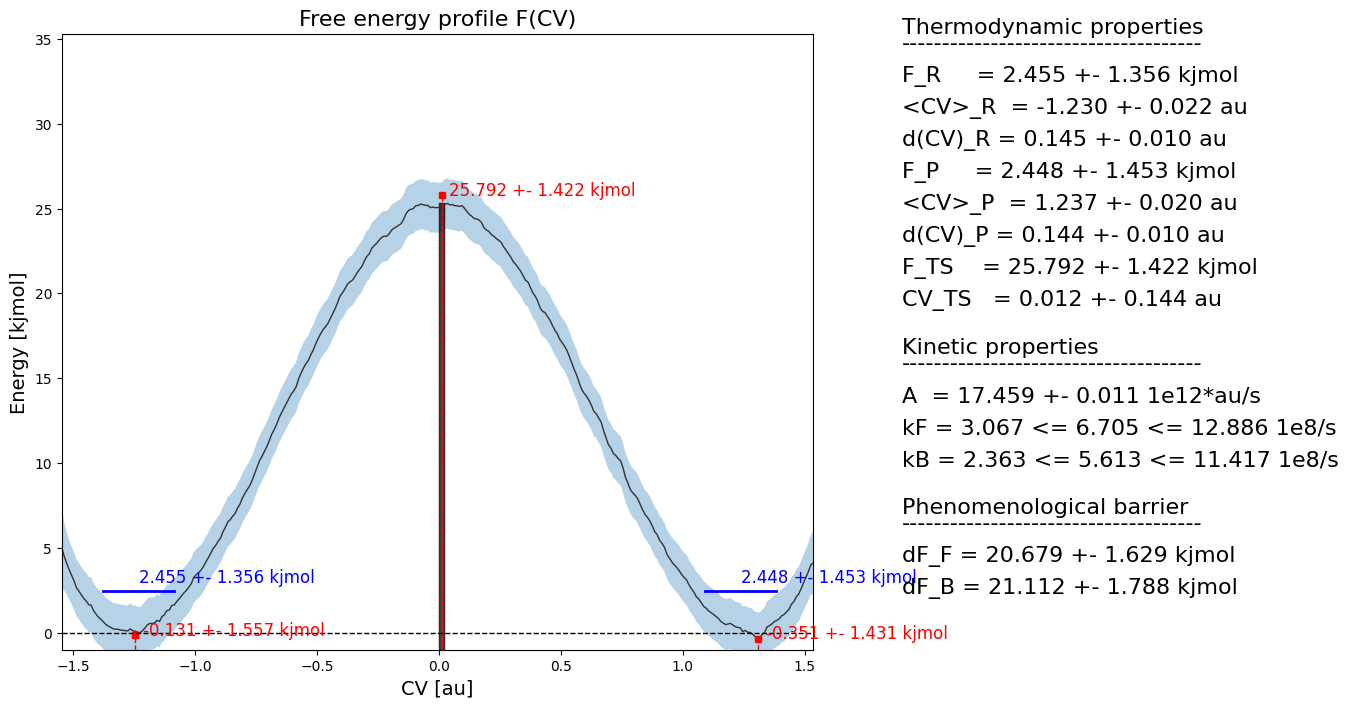

In [15]:
fep.plot(rate=rate, do_latex=False, fn='basic_kinetics.pdf')